# **Laboratorio 7**

Angélica Ortiz <br>  María José Amorocho

# 1. Estudio y Extracción de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn theme
sns.set_theme()

csv_path = './data_transformed.csv'

df = pd.read_csv(csv_path)
df['fecha_completa'] = pd.to_datetime(df['fecha_completa'], format='%Y-%m-%d %H:%M:%S')
df.index = pd.to_datetime(df['fecha_completa'], format='%Y-%m-%d %H:%M:%S')
df.head(10)


,fecha_completa,MES,DIA,MODO_ACCESO,PORTERIA,RESULTADO_EVENTO,ROL,TIPO_ACCESO
fecha_completa,,,,,,,,
2019-02-04 00:53:19,2019-02-04 00:53:19,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
2019-02-04 00:55:43,2019-02-04 00:55:43,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
2019-02-04 00:56:17,2019-02-04 00:56:17,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
2019-02-04 01:16:01,2019-02-04 01:16:01,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,IN
2019-02-04 01:29:41,2019-02-04 01:29:41,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
2019-02-04 01:50:05,2019-02-04 01:50:05,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,OUT
2019-02-04 03:19:58,2019-02-04 03:19:58,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,OUT
2019-02-04 03:38:28,2019-02-04 03:38:28,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,IN
2019-02-04 03:39:15,2019-02-04 03:39:15,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,IN


## Data Pipeline

Crea una pipeline que elimina todas las columnas y filas innecesarias, y crea nuevas columnas para comprender mejor el período de tiempo de los datos.

In [2]:
def extract_transform_load(df: pd.DataFrame):
    """
    Extracts, transforms, and loads data for entry/exit analysis.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        pd.DataFrame, pd.DataFrame: DataFrames containing entries and exits data.
    """
    # Data Cleaning & Preparation
    df_filtered = (
        df.drop(columns=["PORTERIA", "RESULTADO_EVENTO", "ROL"])
        .query("MODO_ACCESO == 'Peatonal'")
        .drop(columns=["MODO_ACCESO"])
    )
    df_filtered["TIPO_ACCESO"] = df_filtered["TIPO_ACCESO"].str.strip()
    df_filtered["DIA"] = pd.to_numeric(df_filtered["DIA"])
    df_filtered.set_index(pd.to_datetime(df_filtered.index), inplace=True)

    # Drop rows with missing values
    df_filtered.dropna(inplace=True)

    # Drop duplicates
    df_filtered.drop_duplicates(inplace=True)
    # Add day of the week
    df_filtered['day_of_week'] = df_filtered.index.day_name()
    
    # Order day of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_filtered['day_of_week'] = pd.Categorical(df_filtered['day_of_week'], categories=day_order, ordered=True)

    # Add week number
    df_filtered['week'] = df_filtered.index.isocalendar().week

    df_filtered['time'] = df_filtered.index.time

    # Separate Entries and Exits
    df_in = df_filtered[df_filtered["TIPO_ACCESO"] == "IN"]
    df_out = df_filtered[df_filtered["TIPO_ACCESO"] == "OUT"]

    return df_in, df_out

## Agrupar las entradas y salidas por hora cada 5 minutos

In [3]:
def entry_exit_by_5min_interval(df: pd.DataFrame):
    """
    Groups entries and exits by 5-minute intervals for each day of the week.

    Args:
        df (pd.DataFrame): Input DataFrame containing access data.

    Returns:
        dict: Dictionary containing DataFrames of grouped entries and exits for each day of the week.
    """
    df_in, df_out = extract_transform_load(df)

    # Initialize dictionaries to hold DataFrames
    df_in_5min = {}
    df_out_5min = {}

    # Group by 5-minute intervals for each day of the week
    for day in df_in['day_of_week'].cat.categories:
        df_in_day = df_in[df_in['day_of_week'] == day].set_index('fecha_completa').resample('5min').size().reset_index(name='Entries')
        df_out_day = df_out[df_out['day_of_week'] == day].set_index('fecha_completa').resample('5min').size().reset_index(name='Exits')

        # Only keep non-zero entries
        df_in_day = df_in_day[df_in_day['Entries'] > 0]
        df_out_day = df_out_day[df_out_day['Exits'] > 0]

        df_in_day['time'] = df_in_day['fecha_completa'].dt.time.astype(str)
        df_out_day['time'] = df_out_day['fecha_completa'].dt.time.astype(str)

        df_in_day.set_index('time', inplace=True)
        df_out_day.set_index('time', inplace=True)

        df_in_5min[day] = df_in_day
        df_out_5min[day] = df_out_day

    return df_in_5min, df_out_5min


def plot_entry_exit_per_5min_interval(df_in_5min: dict, df_out_5min: dict):
    """
    Plots the number of entries and exits per 5-minute interval for each day of the week.

    Args:
        df_in_5min (dict): Dictionary containing DataFrames of entries per 5-minute interval for each day of the week.
        df_out_5min (dict): Dictionary containing DataFrames of exits per 5-minute interval for each day of the week.

    Returns:
        None
    """
    # Plotting for each day of the week
    for day in df_in_5min.keys():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot the entries per 5-minute interval
        sns.lineplot(data=df_in_5min[day], x=df_in_5min[day].index, y='Entries', marker='o', label='Entries', ax=ax, color='red')

        # Plot the exits per 5-minute interval
        sns.lineplot(data=df_out_5min[day], x=df_out_5min[day].index, y='Exits', marker='o', label='Exits', ax=ax, color='blue')

        # Set the title of the plot
        plt.title(f"Number of Entries and Exits per 5-Minute Interval on {day}")

        # Set the x-axis label
        plt.xlabel("Time")

        # Set the y-axis label
        plt.ylabel("Number of Entries/Exits")

        plt.legend()
        plt.show()

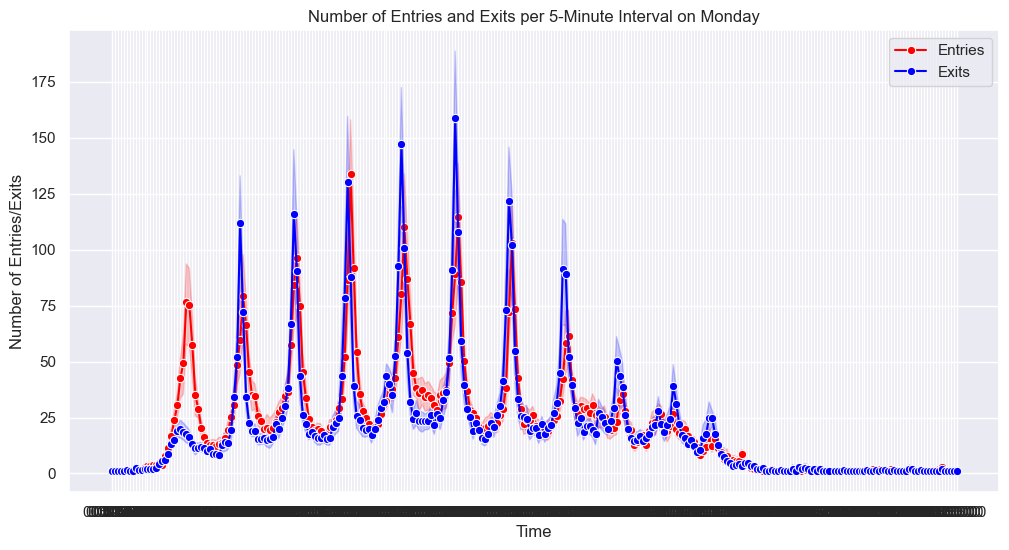

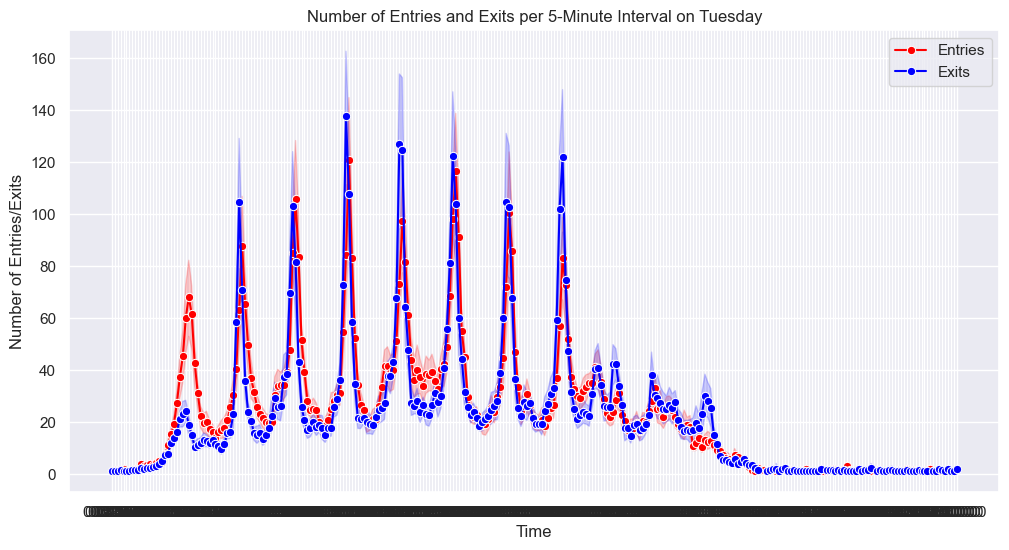

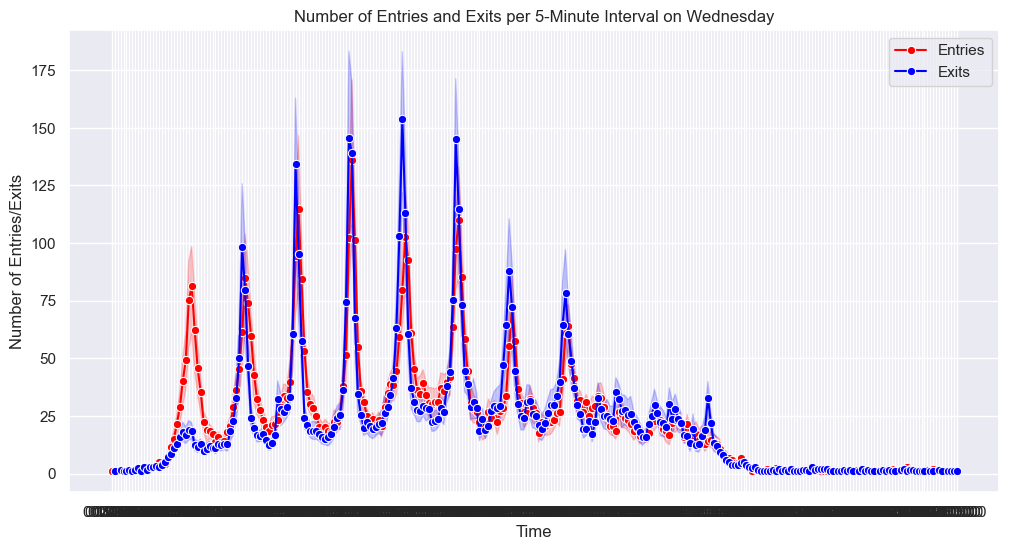

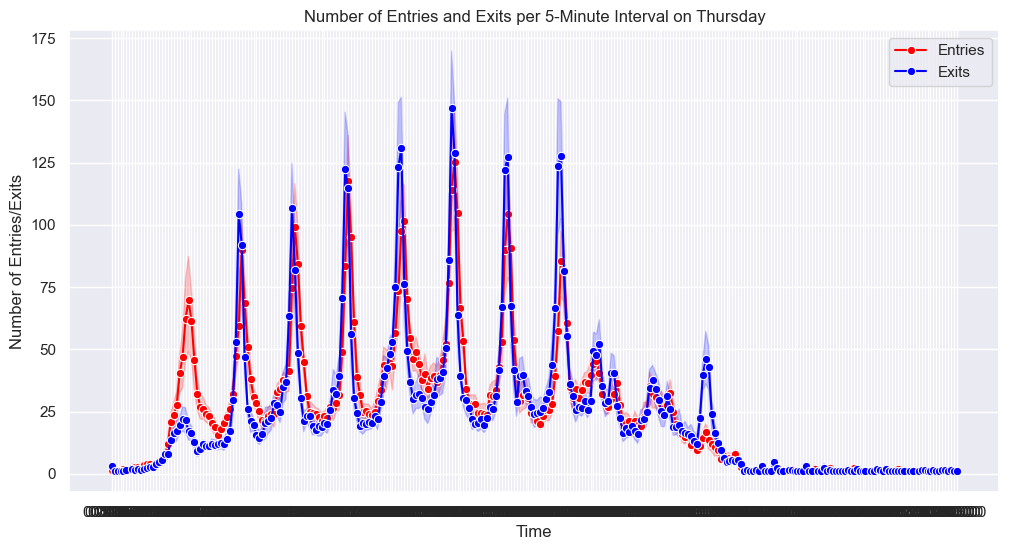

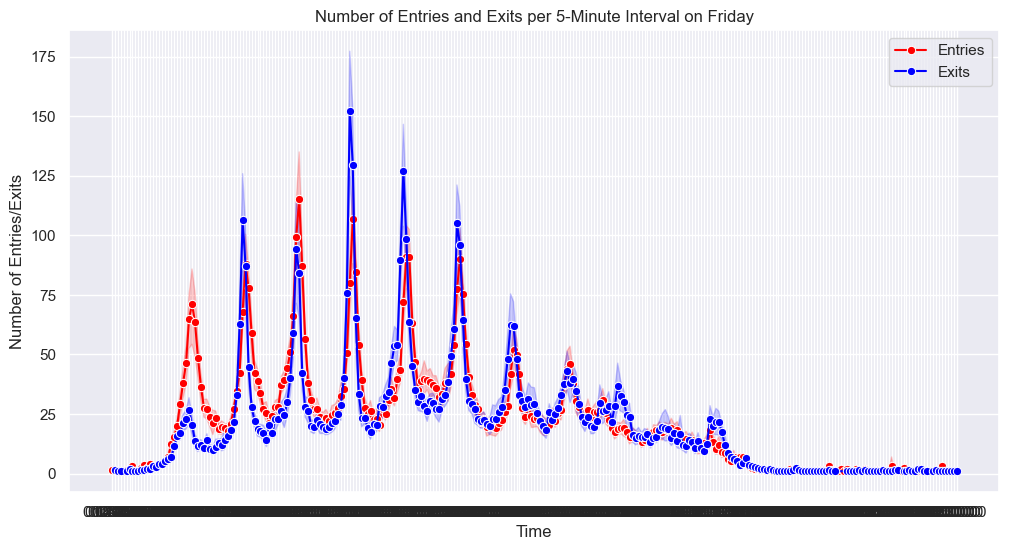

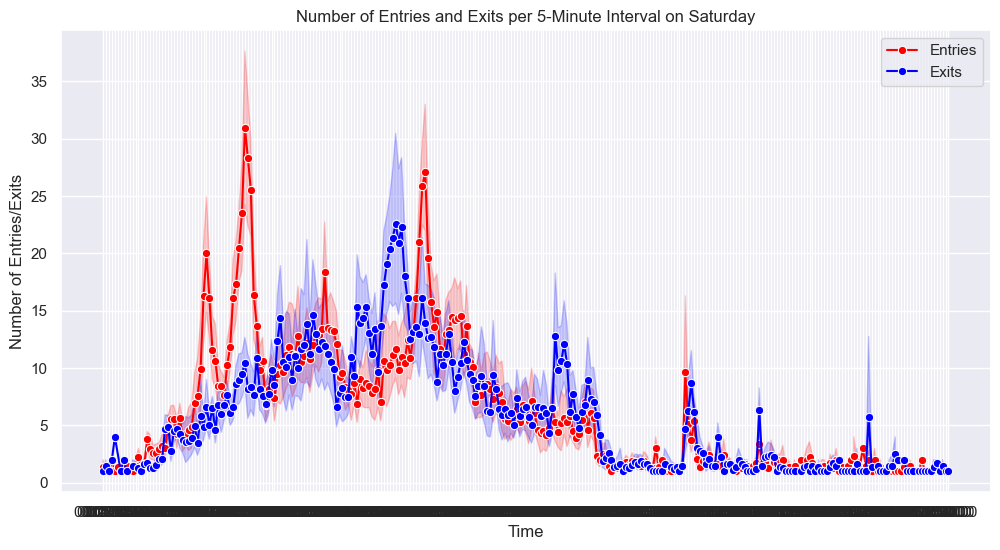

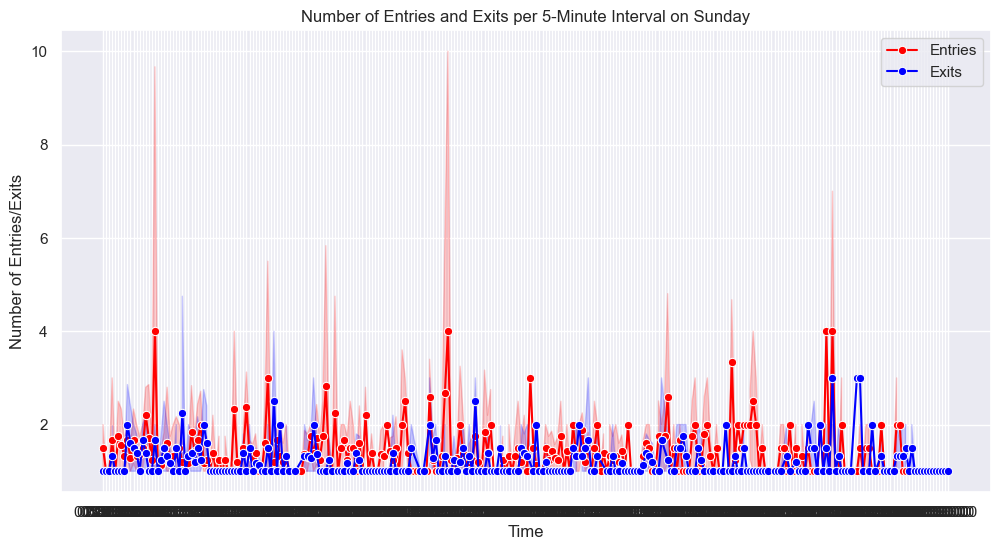

In [4]:
df_in_5min, df_out_5min = entry_exit_by_5min_interval(df)
plot_entry_exit_per_5min_interval(df_in_5min, df_out_5min)

In [5]:
def get_randomized_turnstile_usage(df_in_5min: dict, df_out_5min: dict, day_of_week: str, time: str):
    """
    Returns a random turnstile usage for a given day of the week and time.

    Args:
        df_in_5min (dict): Dictionary containing DataFrames of entries per 5-minute interval for each day of the week.
        df_out_5min (dict): Dictionary containing DataFrames of exits per 5-minute interval for each day of the week.
        day_of_week (str): Day of the week.
        time (str): Time of the day.

    Returns:
        pd.DataFrame: DataFrame containing a random turnstile usage for the given day of the week and time.
    """

    # Randomly select a turnstile usage for the given day of the week and time
    df_in = df_in_5min[day_of_week]
    df_out = df_out_5min[day_of_week]

    # Randomly select a turnstile usage for the given day of the week and time
    avg_entries = df_in.loc[time, 'Entries'].mean()
    avg_exits = df_out.loc[time, 'Exits'].mean()

    # Generate random entries and exits based on the average values and a normal distribution
    np.random.seed(0)
    entries = np.random.normal(avg_entries, 10)
    exits = np.random.normal(avg_exits, 10)

    return entries, exits

In [6]:
df_in_5min, df_out_5min = entry_exit_by_5min_interval(df)

day_of_week = 'Monday'
time = '08:00:00'

entries, exits = get_randomized_turnstile_usage(df_in_5min, df_out_5min, day_of_week, time)

print(f"Random Turnstile Usage for {day_of_week} at {time}")
print("Entries:")
print(entries)
print("\nExits:")
print(exits)

Random Turnstile Usage for Monday at 08:00:00
Entries:
83.89052345967664

Exits:
38.33490541700557


In [7]:
df_out_5min['Sunday'].head()

,fecha_completa,Exits
time,,
02:30:00,2019-02-10 02:30:00,1
03:40:00,2019-02-10 03:40:00,1
03:45:00,2019-02-10 03:45:00,1
04:50:00,2019-02-10 04:50:00,1
05:45:00,2019-02-10 05:45:00,3


# 2. Interpolación de Curva de Densidad Empírica

In [8]:

from scipy.interpolate import interp1d

def convert_to_minutes_since_midnight(time_str):
    """Converts a time string (HH:MM:SS) to minutes since midnight."""
    h, m, s = map(int, time_str.split(":"))
    return h * 60 + m + s / 60

def create_interpolators(df_in_5min: dict, df_out_5min: dict, kind: str = 'cubic'):
    """
    Generates interpolating functions λ(t) for entries and exits for each day of the week.
    Handles duplicate time points by averaging counts per minute.

    Args:
        df_in_5min (dict): Dictionary with DataFrames of 'Entries' per 5-min interval (indexed by 'time' strings).
        df_out_5min (dict): Dictionary with DataFrames of 'Exits' per 5-min interval (indexed by 'time' strings).
        kind (str): Type of interpolation ('linear', 'cubic', etc.).

    Returns:
        Tuple[dict, dict]: Two dictionaries:
            - lambda_in[day]: interp1d for entries,
            - lambda_out[day]: interp1d for exits.
    """
    lambda_in = {}
    lambda_out = {}

    for day in df_in_5min.keys():
        # Process entries
        df_in = df_in_5min[day].reset_index()
        df_in['minute'] = df_in['time'].map(convert_to_minutes_since_midnight)
        # Group by minute to handle duplicates (take mean)
        df_in_grouped = df_in.groupby('minute', sort=True)['Entries'].mean().reset_index()
        minutes_in = df_in_grouped['minute'].values
        entries = df_in_grouped['Entries'].values
        f_in = interp1d(minutes_in, entries, kind=kind, fill_value="extrapolate")

        # Process exits
        df_out = df_out_5min[day].reset_index()
        df_out['minute'] = df_out['time'].map(convert_to_minutes_since_midnight)
        df_out_grouped = df_out.groupby('minute', sort=True)['Exits'].mean().reset_index()
        minutes_out = df_out_grouped['minute'].values
        exits = df_out_grouped['Exits'].values
        f_out = interp1d(minutes_out, exits, kind=kind, fill_value="extrapolate")

        # Store in dictionaries
        lambda_in[day] = f_in
        lambda_out[day] = f_out

    return lambda_in, lambda_out

# Ejemplo de uso:
lambda_in, lambda_out = create_interpolators(df_in_5min, df_out_5min, kind='cubic')
# Tasa de llegadas estimada para 'Monday' a las 08:15 (495 minutos):
print(lambda_in['Monday'](495))



34.46666666666667


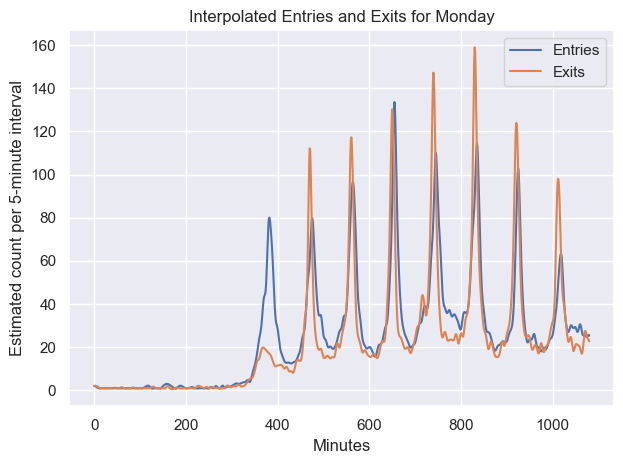

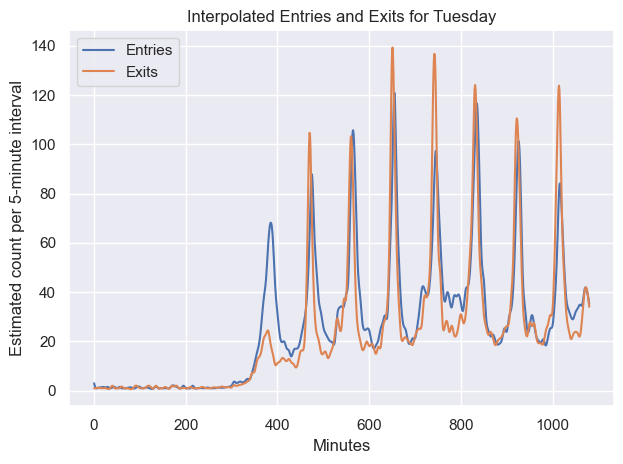

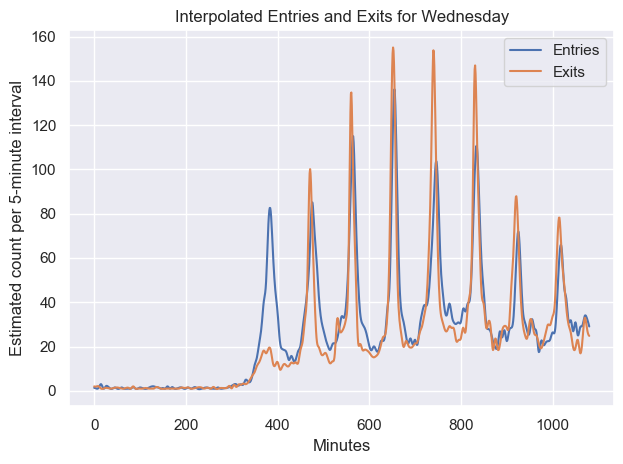

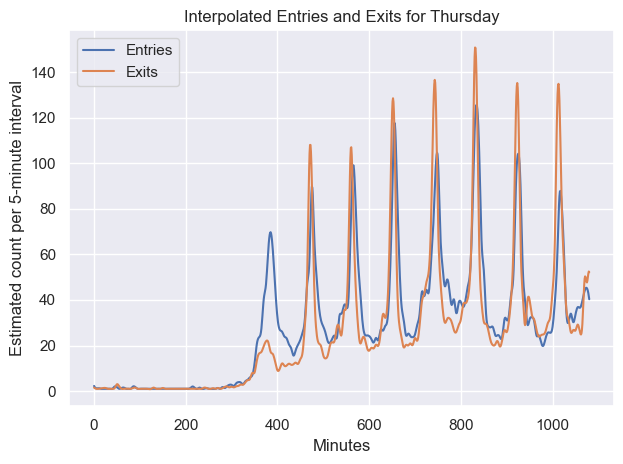

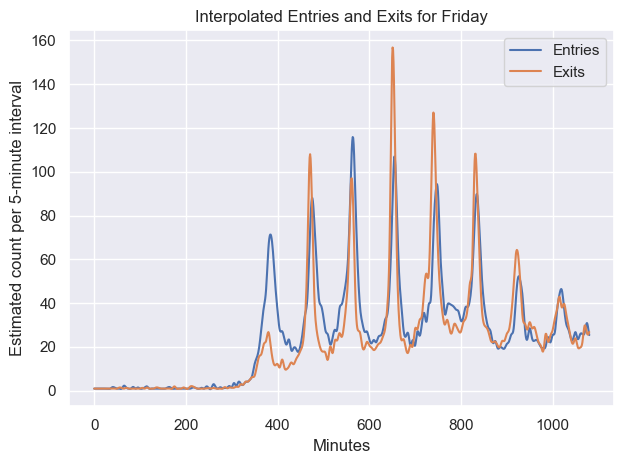

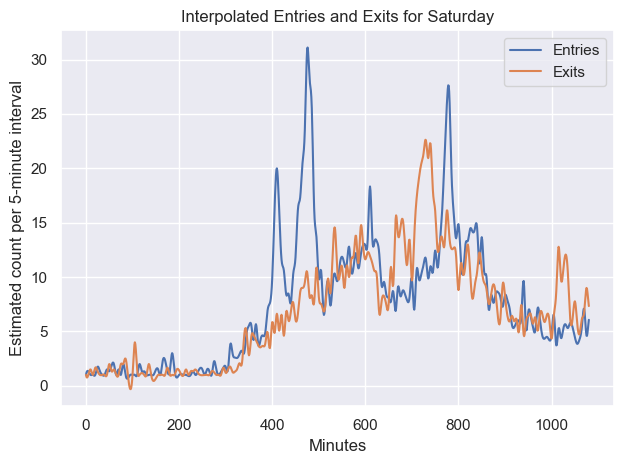

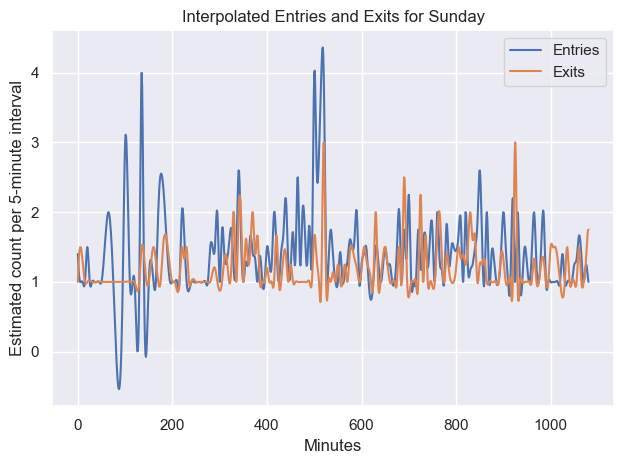

In [ ]:
def plot_interpolation_curves(lambda_in: dict, lambda_out: dict, resolution: int = 1):
    """
    Plots interpolated entry and exit rate curves for each day of the week.

    Args:
        lambda_in (dict): Dictionary of interpolators for entries per day.
        lambda_out (dict): Dictionary of interpolators for exits per day.
        resolution (int): Time step in minutes for plotting (default 1 minute).
    """
    days = list(lambda_in.keys())
    # Time grid: minutes from 0 to 1440 (full day)
    t_grid = np.arange(0, 18*60 + resolution, resolution)

    for day in days:
        f_in = lambda_in[day]
        f_out = lambda_out[day]

        # Evaluate interpolators on the grid
        y_in = f_in(t_grid)
        y_out = f_out(t_grid)

        # Create a new figure for each day
        plt.figure()
        plt.plot(t_grid, y_in, label='Entries')
        plt.plot(t_grid, y_out, label='Exits')
        plt.title(f'Interpolated Entries and Exits for {day}')
        plt.xlabel('Minutes')
        plt.ylabel('Estimated count per 5-minute interval')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejemplo de uso
plot_interpolation_curves(lambda_in, lambda_out, resolution=5)


# 3. Creación de la Simulación

In [18]:
import simpy
import random
import itertools
from collections import defaultdict
import pandas as pd

def get_interval_key(time_seconds):
    total_minutes = int(time_seconds // 60)
    interval_start = total_minutes - (total_minutes % 5)
    hh = interval_start // 60
    mm = interval_start % 60
    return f"{hh:02d}:{mm:02d}:00"

class MonitoredResource(simpy.Resource):
    """Extends SimPy Resource to monitor queue length and utilization."""
    def __init__(self, env, capacity, name, monitor_data):
        super().__init__(env, capacity=capacity)
        self.env = env
        self.name = name
        self.monitor_data = monitor_data  # dict to store metrics
        self._busy_start = []  # list of start times for each usage

    def request(self, *args, **kwargs):
        req = super().request(*args, **kwargs)
        # attach a callback to record queue length when request is made
        self.monitor_data['queue_length'][self.name].append((self.env.now, len(self.queue)))
        return req

    def release(self, req):
        # record utilization end time
        if self._busy_start:
            start = self._busy_start.pop(0)
            busy_time = self.env.now - start
            self.monitor_data['busy_time'][self.name] += busy_time
        return super().release(req)

    def _do_put(self, event):
        # override to record busy start when a user starts service
        self.monitor_data['queue_length'][self.name].append((self.env.now, len(self.queue)))
        self._busy_start.append(self.env.now)
        return super()._do_put(event)

class TurnstileSystem:
    def __init__(self, env, monitor_data):
        self.env = env
        # Create monitored resources
        self.entry_normal = MonitoredResource(env, capacity=3, name='entry_normal', monitor_data=monitor_data)
        self.exit_normal  = MonitoredResource(env, capacity=3, name='exit_normal',  monitor_data=monitor_data)
        self.entry_qr     = MonitoredResource(env, capacity=1, name='entry_qr',     monitor_data=monitor_data)
        self.exit_qr      = MonitoredResource(env, capacity=1, name='exit_qr',      monitor_data=monitor_data)

def person(env, name, direction, system, monitor_data):
    arrival_time = env.now
    prep_time = max(random.gauss(10, 2), 0.1)
    yield env.timeout(prep_time)

    use_qr = (random.random() < 0.1)
    if direction == 'entry':
        resource = system.entry_qr if use_qr else system.entry_normal
        service_time = max(random.gauss(20, 2) if use_qr else random.gauss(5, 2), 0.1)
    else:
        resource = system.exit_qr if use_qr else system.exit_normal
        service_time = max(random.gauss(20, 2) if use_qr else random.gauss(5, 2), 0.1)

    with resource.request() as req:
        start_wait = env.now
        yield req
        wait_time = env.now - start_wait
        # Record wait time with resource info
        monitor_data['wait_times'].append({
            'resource': resource.name,
            'direction': direction,
            'wait_time': wait_time,
            'timestamp': env.now    # guardamos el tiempo en segundos
        })
        yield env.timeout(service_time)
        key = get_interval_key(env.now)
        monitor_data['counts'][direction][key] += 1
        
def arrival_generator(env, day, lambda_dict, direction, system, monitor_data):
    count = itertools.count()
    while True:
        minute = env.now / 60
        expected = max(lambda_dict[day](minute), 0)
        rate = expected / 300.0
        if rate > 0:
            interarrival = random.expovariate(rate)
            yield env.timeout(interarrival)
            env.process(person(env, f"Person {next(count)}", direction, system, monitor_data))
        else:
            yield env.timeout(60)
            
def monitor_queues(env, system, monitor_data, interval=60):
    """Samples queue lengths at fixed intervals."""
    while True:
        for res in [system.entry_normal, system.exit_normal, system.entry_qr, system.exit_qr]:
            monitor_data['queue_length'][res.name].append((env.now, len(res.queue)))
        yield env.timeout(interval)

def run_simulation(day, lambda_in, lambda_out, sim_time=12*3600, seed=42):
    random.seed(seed)
    env = simpy.Environment()
    monitor_data = {
        'counts': {'entry': defaultdict(int), 'exit': defaultdict(int)},
        'wait_times': [],  # list of dicts {'resource','direction','wait_time','timestamp'}
        'busy_time': defaultdict(float),
        'queue_length': defaultdict(list)
    }
    system = TurnstileSystem(env, monitor_data)
    env.process(arrival_generator(env, day, lambda_in, 'entry', system, monitor_data))
    env.process(arrival_generator(env, day, lambda_out, 'exit', system, monitor_data))
    env.process(monitor_queues(env, system, monitor_data, interval=60))
    env.run(until=sim_time)

    df_wait = pd.DataFrame(monitor_data['wait_times'])
    utilization = {res: busy / sim_time for res, busy in monitor_data['busy_time'].items()}
    df_queue = {res: pd.DataFrame(data, columns=['time', 'queue_length']) 
                for res, data in monitor_data['queue_length'].items()}
    df_counts_in  = pd.Series(monitor_data['counts']['entry'], name='Entries').sort_index().to_frame()
    df_counts_out = pd.Series(monitor_data['counts']['exit'],  name='Exits').sort_index().to_frame()

    return {
        'wait_times': df_wait,
        'utilization': utilization,
        'queue_lengths': df_queue,
        'entry_counts': {day: df_counts_in},
        'exit_counts': {day: df_counts_out}
    }

result =run_simulation("Monday", lambda_in, lambda_out, sim_time=18*3600, seed=42)

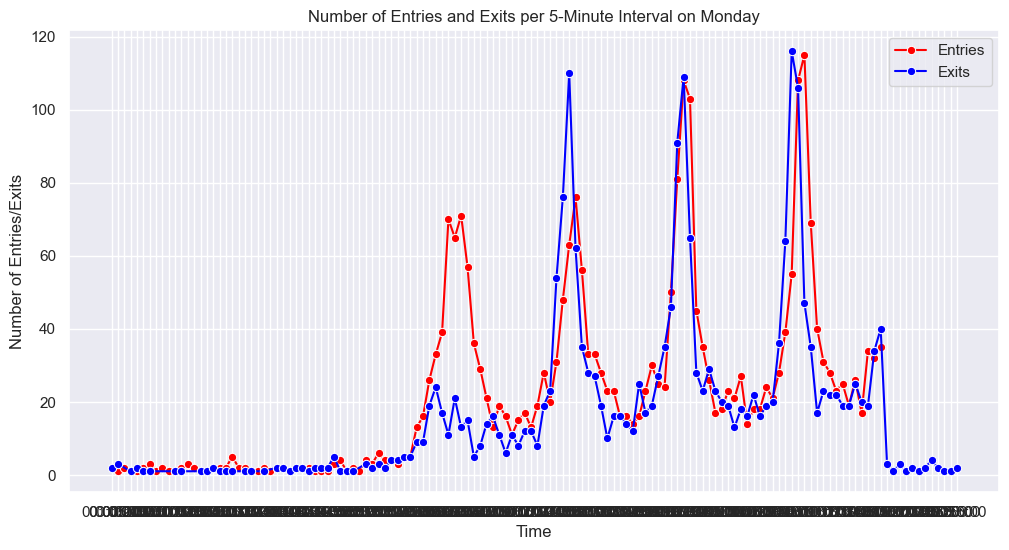

In [19]:
result = run_simulation("Monday", lambda_in, lambda_out, sim_time=12*3600, seed=42)
plot_entry_exit_per_5min_interval(result['entry_counts'], result['exit_counts'])

In [20]:

def calcular_estadisticas(result: dict):
    """
    Imprime estadísticas de una simulación de torniquetes para un día:
      - Promedio de espera por torniquete (segmentado por entrada/salida y normal/QR).
      - Porcentaje de utilización de cada torniquete.
      - Promedio de longitud de cola por torniquete.
    
    Args:
        result (dict): Salida de run_simulation, con llaves:
            - 'wait_times': DataFrame con columnas ['resource', 'wait_time'].
            - 'utilization': dict {resource_name: utilizacion (0-1)}.
            - 'queue_lengths': dict {resource_name: DataFrame(time, queue_length)}.
    """
    # Extraer estructuras
    wait_df = result['wait_times']
    util = result['utilization']
    queue_lengths = result['queue_lengths']
    
    # 1. Promedio de espera
    print("Promedio de tiempo de espera por torniquete:")
    for resource, grp in wait_df.groupby('resource'):
        avg_wait = grp['wait_time'].mean()
        print(f"  - {resource}: {avg_wait:.2f} s")
    
    # 2. Porcentaje de utilización
    print("\nPorcentaje de utilización de cada torniquete:")
    for resource, usage in util.items():
        print(f"  - {resource}: {usage:.2f}%")
    
    # 3. Promedio de longitud de cola
    print("\nPromedio de longitud de cola por torniquete:")
    for resource, df in queue_lengths.items():
        avg_queue = df['queue_length'].mean()
        print(f"  - {resource}: {round(avg_queue)} personas")
        
calcular_estadisticas(result)

Promedio de tiempo de espera por torniquete:
  - entry_normal: 0.13 s
  - entry_qr: 5.90 s
  - exit_normal: 0.19 s
  - exit_qr: 6.22 s

Porcentaje de utilización de cada torniquete:
  - exit_normal: 32.39%
  - exit_qr: 8.11%
  - entry_normal: 30.31%
  - entry_qr: 14.35%

Promedio de longitud de cola por torniquete:
  - entry_normal: 1 personas
  - exit_normal: 1 personas
  - entry_qr: 0 personas
  - exit_qr: 0 personas


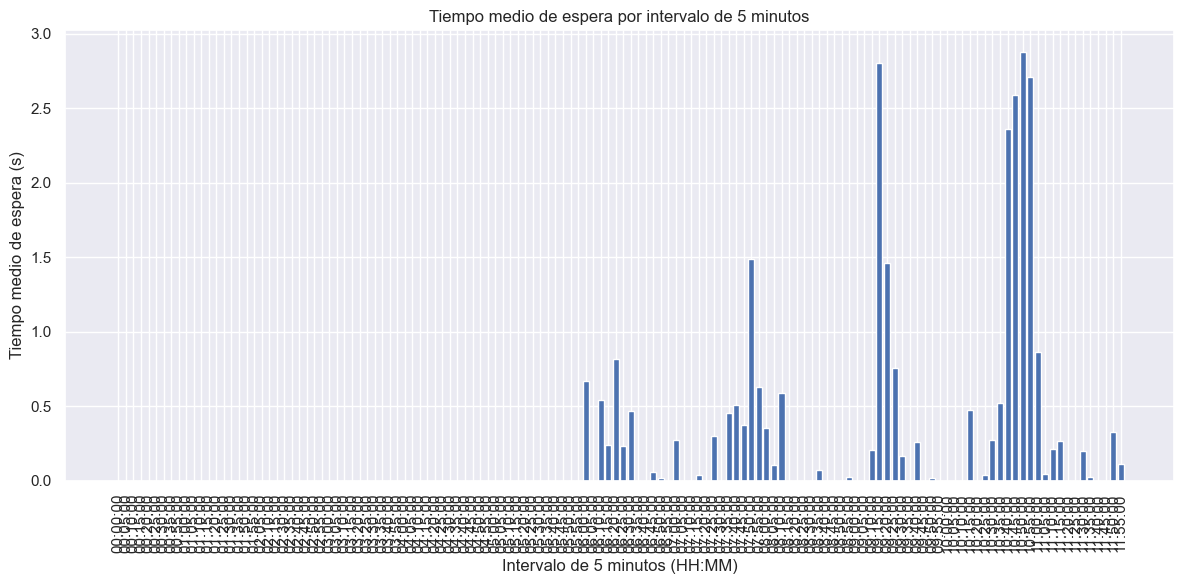

In [21]:
def graficar_tiempo_espera(result: dict):
    """
    Grafica el tiempo medio de espera de los torniquetes por intervalos de 5 minutos.

    Args:
        result (dict): Salida de run_simulation, con 'wait_times' DataFrame 
                       que debe incluir columna 'timestamp' (segundos desde inicio).
    """
    df_wait = result['wait_times']
    
    if 'timestamp' not in df_wait.columns:
        raise ValueError("El DataFrame 'wait_times' debe incluir columna 'timestamp' con el tiempo de espera registrado.")
    
    # Función para convertir segundos a clave de intervalo 'HH:MM:00'
    def get_interval_key(time_seconds):
        total_minutes = int(time_seconds // 60)
        interval_start = total_minutes - (total_minutes % 5)
        hh = interval_start // 60
        mm = interval_start % 60
        return f"{hh:02d}:{mm:02d}:00"
    
    # Asignar cada evento de espera a su intervalo de 5 minutos
    df_wait['interval'] = df_wait['timestamp'].apply(get_interval_key)
    
    # Calcular tiempo de espera medio por intervalo
    df_mean = df_wait.groupby('interval')['wait_time'].mean().reset_index()
    
    # Ordenar por hora usando minutos desde medianoche
    def to_minutes(interval_str):
        h, m, _ = map(int, interval_str.split(':'))
        return h * 60 + m
    df_mean['order'] = df_mean['interval'].apply(to_minutes)
    df_mean = df_mean.sort_values('order')
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(df_mean['interval'], df_mean['wait_time'])
    ax.set_xlabel("Intervalo de 5 minutos (HH:MM)")
    ax.set_ylabel("Tiempo medio de espera (s)")
    ax.set_title("Tiempo medio de espera por intervalo de 5 minutos")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

graficar_tiempo_espera(result)